In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import warnings
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFECV
from catboost import CatBoostClassifier

plt.style.use('seaborn-bright')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
combine_data = [train_data, test_data]
for df in combine_data:
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand = True)
    df[['PGroup','PNr']] = df['PassengerId'].str.split('_', expand=True)

    df['Num'] = df['Num'].astype('float')
    df['PNr'] = df['PNr'].astype('float')
    df['PGroup'] = df['PGroup'].astype('float')

train_data[['Deck', 'Num', 'Side', 'PGroup', 'PNr']].head()

,Deck,Num,Side,PGroup,PNr
0,B,0.0,P,1.0,1.0
1,F,0.0,S,2.0,1.0
2,A,0.0,S,3.0,1.0
3,A,0.0,S,3.0,2.0
4,F,1.0,S,4.0,1.0


In [7]:
combine_data = [train_data, test_data]
for data in combine_data:
    data.Num = data.Num.astype('float32')
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,PGroup,PNr
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,1.0,1.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,2.0,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,3.0,1.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,3.0,2.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,4.0,1.0


In [66]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 240
sns.set_theme(style="darkgrid")

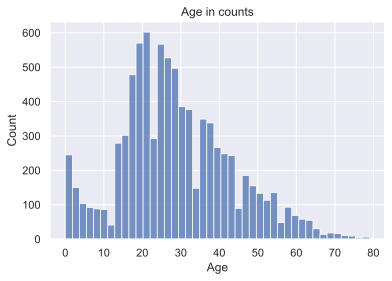

In [19]:

plt.title("Age in counts")
sns.histplot(data=train_data, x="Age")
plt.savefig('img/5.png')

In [12]:
train_data[train_data['Age']<1]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,PGroup,PNr
19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Lyde Brighttt,True,G,0.0,P,17.0,1.0
61,0067_01,Earth,True,G/10/S,PSO J318.5-22,0.0,False,0.0,0.0,0.0,0.0,0.0,Ninaha Leeves,True,G,10.0,S,67.0,1.0
86,0092_02,Earth,True,G/9/P,TRAPPIST-1e,0.0,False,0.0,0.0,NaN,0.0,0.0,Stald Hewson,True,G,9.0,P,92.0,2.0
102,0108_03,Earth,False,G/19/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Oline Handertiz,True,G,19.0,S,108.0,3.0
157,0179_02,Earth,False,G/26/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Raque Webstephrey,False,G,26.0,P,179.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,9074_01,Earth,True,G/1460/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,NaN,0.0,0.0,Adamie Trerady,True,G,1460.0,S,9074.0,1.0
8584,9163_01,Earth,True,G/1477/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Idace Edwartizman,True,G,1477.0,S,9163.0,1.0
8650,9227_04,Earth,True,G/1498/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Robyny Hinglendez,True,G,1498.0,P,9227.0,4.0
8654,9231_02,Mars,False,F/1888/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Walls Paie,True,F,1888.0,P,9231.0,2.0


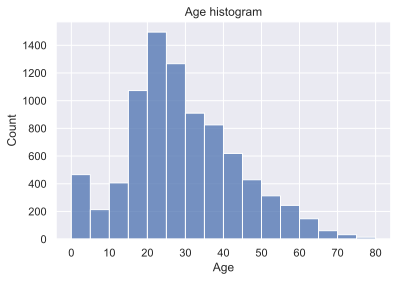

In [38]:
plt.title("Age histogram")
sns.histplot(data=train_data, x="Age", binwidth=5)
plt.savefig('img/6.png')

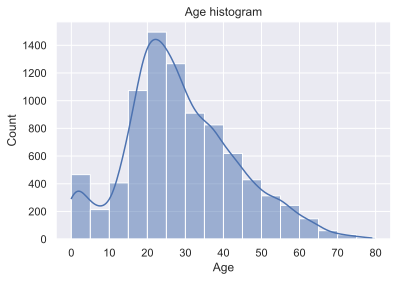

In [39]:
plt.title("Age histogram")
sns.histplot(data=train_data, x="Age", binwidth=5, kde=True)
plt.savefig('img/7.png')

In [45]:
train_data["Age"].skew()

0.41909658301471536

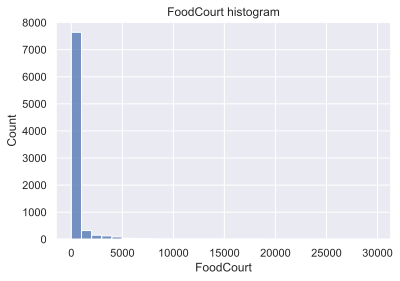

In [40]:
plt.title("FoodCourt histogram")
sns.histplot(data=train_data, x="FoodCourt", bins=30)
plt.savefig('img/8.png')

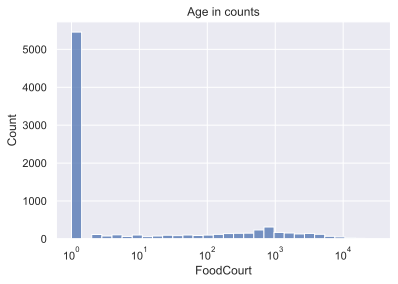

In [43]:
tmp_df = train_data[["FoodCourt"]] + 1
plt.title("Age in counts")
sns.histplot(data=tmp_df, x="FoodCourt", bins=30, log_scale=True)
plt.savefig('img/9.png')

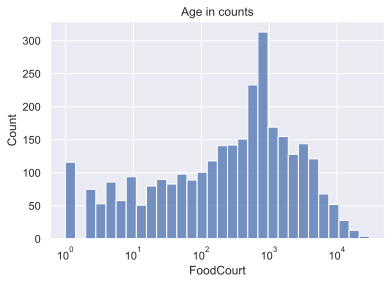

In [44]:
plt.title("Age in counts")
sns.histplot(data=train_data[train_data["FoodCourt"]!=0], x="FoodCourt", bins=30, log_scale=True)
plt.savefig('img/10.png')

In [47]:
train_data[train_data["FoodCourt"]!=0]["FoodCourt"].skew()

4.365763119304279

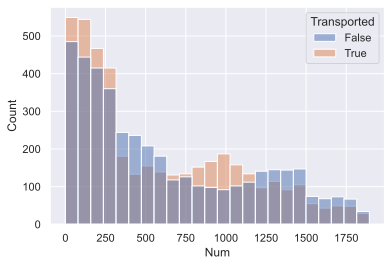

In [52]:
sns.histplot(data=train_data, x="Num", hue='Transported')
plt.savefig('img/11.png')

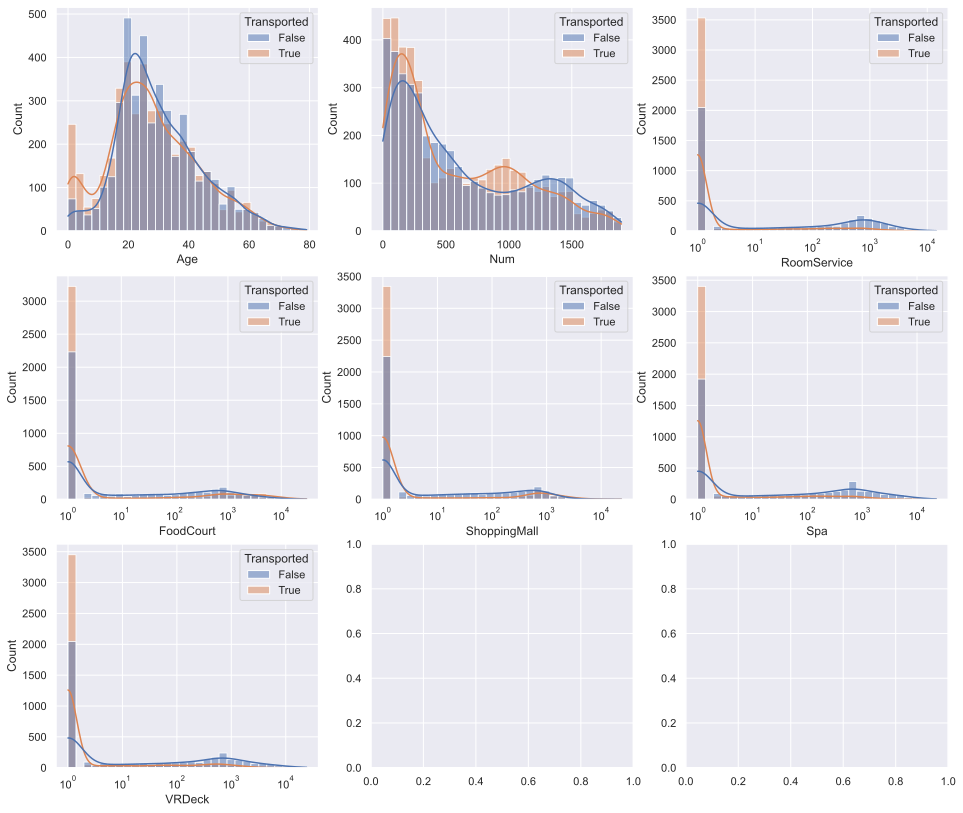

In [80]:
columns=['Age', 'Num', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
row, col = divmod(len(columns), 3)
fig, ax = plt.subplots(row + 1, 3, figsize=(16,14))
for idx, column in enumerate(columns):
    row, col = divmod(idx, 3)
    if column in ['Age', 'Num']:
        sns.histplot(data=train_data, x=column, hue='Transported', ax=ax[row, col], kde=True, bins=30)
    else:
        tmp_df = train_data[[column]] + 1
        tmp_df['Transported'] = train_data['Transported']
        sns.histplot(data=tmp_df, x=column, hue='Transported', ax=ax[row, col], log_scale=True, kde=True, bins=30)
plt.savefig('img/12.png', bbox_inches='tight', pad_inches = 0.2)

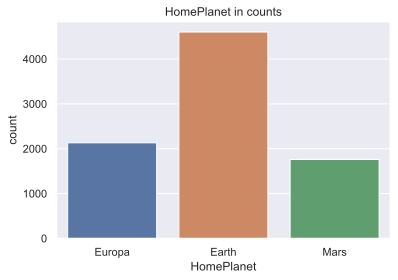

In [69]:
plt.title("HomePlanet in counts")
sns.countplot(data=train_data, x="HomePlanet")
plt.savefig('img/13.png')

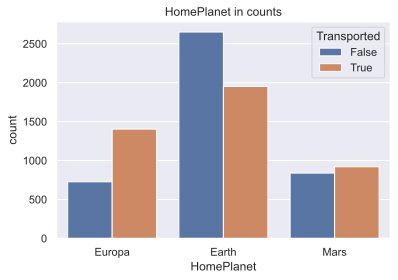

In [71]:
plt.title("HomePlanet in counts")
sns.countplot(data=train_data, x="HomePlanet", hue="Transported")
plt.savefig('img/14.png')

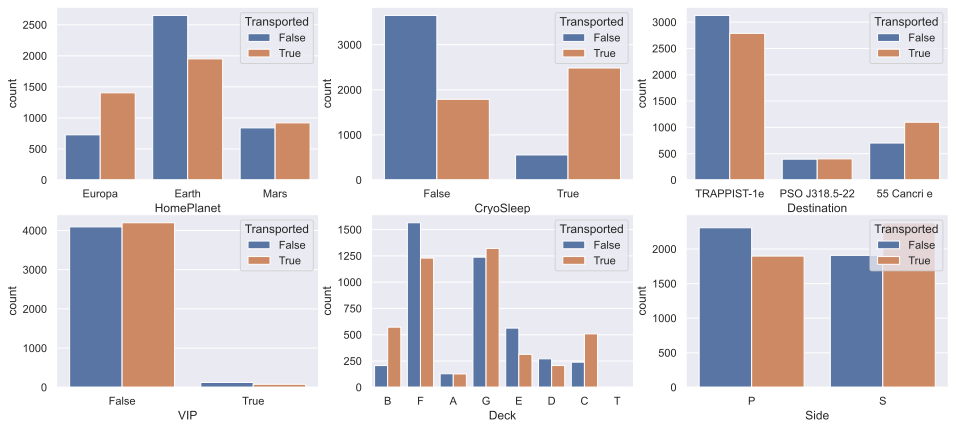

In [89]:
columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
row, col = divmod(len(columns), 3)
fig, ax = plt.subplots(row, 3, figsize=(16,7))
for idx, column in enumerate(columns):
    row, col = divmod(idx, 3)
    sns.countplot(data=train_data, x=column, hue='Transported', ax=ax[row, col])
plt.savefig('img/15.png', bbox_inches='tight', pad_inches = 0.2)

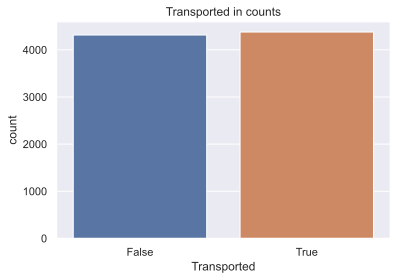

In [82]:
plt.title("Transported in counts")
sns.countplot(data=train_data, x="Transported")
plt.savefig('img/16.png')

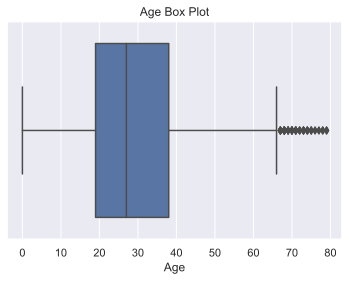

In [87]:
plt.title("Age Box Plot")
sns.boxplot(data=train_data, x="Age")
plt.savefig('img/17.png')

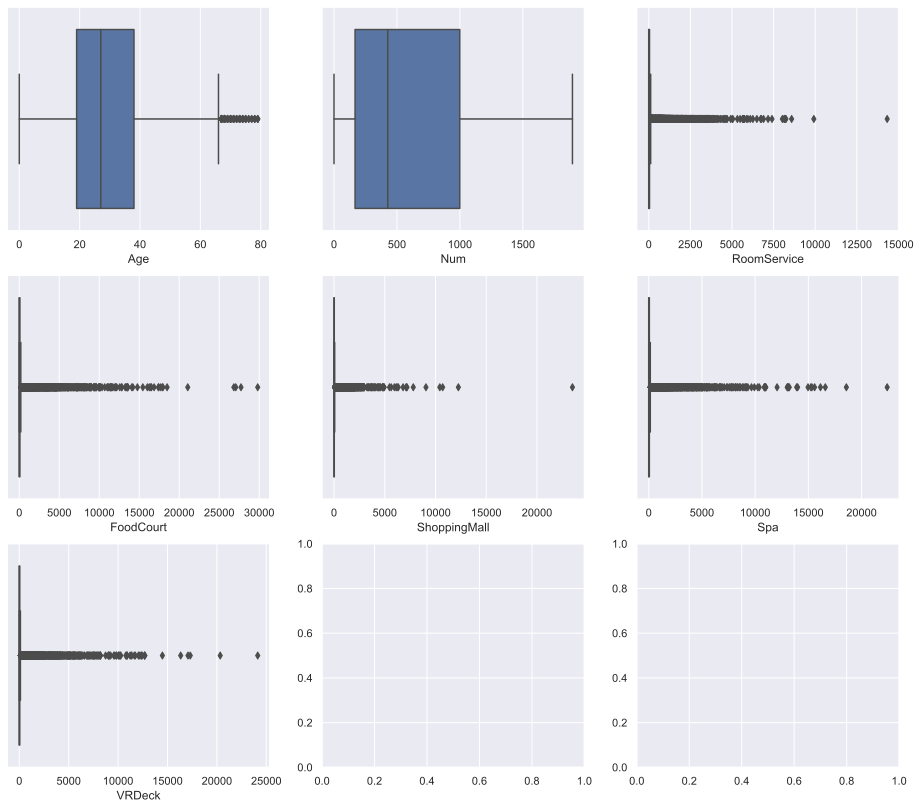

In [90]:
columns=['Age', 'Num', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
row, col = divmod(len(columns), 3)
fig, ax = plt.subplots(row + 1, 3, figsize=(16,7))
for idx, column in enumerate(columns):
    row, col = divmod(idx, 3)
    sns.boxplot(data=train_data, x=column, ax=ax[row, col])
plt.savefig('img/18.png', bbox_inches='tight', pad_inches = 0.2)